=> loading checkpoint './results/models_ex/model_True.pth.tar'
Model loaded from ./results/models_ex/model_True.pth.tar
6 9 h_w_size


/home/zack/anaconda3/envs/python38/lib/python3.6/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


0.9081115308734201


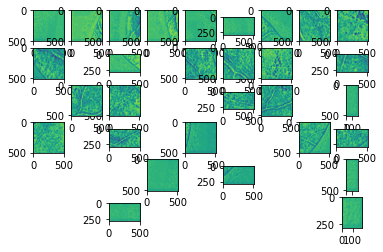

In [11]:

import sys
from torch.autograd import Variable
import os
from optparse import OptionParser
import numpy as np
import random
import copy
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score, auc

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler

import config_gan_ex as config
from hednet import HNNNet
from dnet import DNet
from utils import get_images
from dataset import IDRIDDataset
from torchvision import datasets, models, transforms
from transform.transforms_group import *
from torch.utils.data import DataLoader, Dataset
import argparse

import matplotlib.pyplot as plt

plt.figure()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_size = config.IMAGE_SIZE
image_dir = config.IMAGE_DIR

softmax = nn.Softmax(1)

def eval_model(model, eval_loader):
    model.eval()
    masks_soft = []
    masks_hard = []

    with torch.set_grad_enabled(False):
        num_test_img = 1
        for inputs, true_masks in eval_loader:
            inputs = inputs.to(device=device, dtype=torch.float)
            true_masks = true_masks.to(device=device, dtype=torch.float)
            bs, _, h, w = inputs.shape
            # not ignore the last few patches
            h_size = (h - 1) // image_size + 1
            w_size = (w - 1) // image_size + 1
            masks_pred = torch.zeros(true_masks.shape).to(dtype=torch.float)
            print(h_size,w_size,'h_w_size')
            for i in range(h_size):
                for j in range(w_size):
                    h_max = min(h, (i + 1) * image_size)
                    w_max = min(w, (j + 1) * image_size)
                    
                    inputs_part = inputs[:,:, i*image_size:h_max, j*image_size:w_max]
                    
                    masks_pred_single = model(inputs_part)[-1]
                    masks_pred[:, :, i*image_size:h_max, j*image_size:w_max] = masks_pred_single
                    # plt.subplot(h_size,w_size,(i+1)*(j+1))
                    # plt.imshow(masks_pred_single.cpu().numpy()[0][0])
                    ## 分块分割
            masks_pred_softmax_batch = softmax(masks_pred).cpu().numpy()
            masks_soft_batch = masks_pred_softmax_batch[:, 1:, :, :]
            masks_hard_batch = true_masks[:,1:].cpu().numpy()
            # plt.subplot(1,2,num_test_img)
            # plt.imshow(masks_hard_batch[0][0])
            masks_soft.extend(masks_soft_batch)
            masks_hard.extend(masks_hard_batch)
            break

    masks_soft = np.array(masks_soft).transpose((1, 0, 2, 3))
    masks_hard = np.array(masks_hard).transpose((1, 0, 2, 3))
    masks_soft = np.reshape(masks_soft, (masks_soft.shape[0], -1))
    masks_hard = np.reshape(masks_hard, (masks_hard.shape[0], -1))

    masks_hard = masks_hard[0].astype(np.int)
    masks_soft = masks_soft[0]
    ap = average_precision_score(masks_hard, masks_soft)
    return ap
    
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', type=int, default=1234)
    parser.add_argument('--model', type=str)
    parser.add_argument('--lesion', type=str)
    args = parser.parse_args(['--model','./results/models_ex/model_True.pth.tar','--lesion','EX'])
    #Set random seed for Pytorch and Numpy for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(args.seed)
    np.random.seed(args.seed)
    random.seed(args.seed)

    model = HNNNet(pretrained=True, class_number=2)

    resume = args.model

    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']+1
        start_step = checkpoint['step']
        try:
            model.load_state_dict(checkpoint['state_dict'])
        except:
            model.load_state_dict(checkpoint['g_state_dict'])
        print('Model loaded from {}'.format(resume))
    else:
        print("=> no checkpoint found at '{}'".format(resume))

    model.to(device)

    test_image_paths, test_mask_paths = get_images(image_dir, config.PREPROCESS, phase='test')

    test_dataset = IDRIDDataset(test_image_paths, test_mask_paths, config.LESION_IDS[args.lesion], \
       transform=Compose([Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),]))

    test_loader = DataLoader(test_dataset, 1, shuffle=False)
    auc_result = eval_model(model, test_loader)
    print(auc_result)

    
